# Prueba Isolation Forest para la detección de anomalías

## Isolation Forest

**IF** es un método no supervisado para identificar anomalías (*outliers*) cuando los datos no están etiquetados, es decir, no se conoce la clasificación real (anomalía - no anomalía) de las observaciones. Su funcionamiento está inspirado en el algoritmo de clasificación y regresión *Random Forest*.

## Librerías

In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

from os import getcwd
import math
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 80)

In [2]:
def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'], save=False, save_as='MyFigure.png', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(save_as, dpi=100)

In [8]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max, save=False, save_as="Myfigure.png"):
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for " + estimator, fontsize=24)
    
    plt.xlabel(estimator)
    plt.ylabel('Score')
    plt.grid()
    
    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    pad = 0.005
    X_axis = np.array(results['param_' + estimator].data, dtype=float)
    
    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        sample = 'test' 
        style = '-'
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std, + sample_score_mean + sample_score_std, alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color, label='%s (%s)' % (scorer, sample))
            
        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]
            
        ax.plot([X_axis[best_index], ] * 2, [0, best_score], linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)
            
        ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score+pad))
        print(X_axis[best_index])
        
    plt.legend(loc='best')
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(save_as, dpi=100)

## Carga del conjunto de datos

In [4]:
df = pd.read_csv(getcwd() + "/../../Processed Traffic Data for ML Algorithms/New-Friday-16-02-2018_TrafficForML_CICFlowMeter.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,5.630000e+07,1.385929e+02,56300000,56300000,113000000,5.630000e+07,1.385929e+02,56300000,56300000,0,0.0000,0.000,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56300000.0,138.592929,56300000,56300000,Benign
1,0,0,16/02/2018 08:30:12,112641773,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,5.630000e+07,2.637508e+02,56300000,56300000,113000000,5.630000e+07,2.637508e+02,56300000,56300000,0,0.0000,0.000,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56300000.0,263.750829,56300000,56300000,Benign
2,35605,6,16/02/2018 08:26:55,20784143,23,44,2416,1344,240,64,105.043478,54.542292,64,0,30.545455,32.336497,180.907146,3.223611,3.149113e+05,1.145954e+06,9058214,66,20700000,9.404843e+05,1.898330e+06,9144734,66,20700000,482352.2093,1396411.114,9058214,41601,1,0,0,0,460,880,1.106613,2.116999,0,240,56.235294,53.851681,2900.003512,0,1,0,0,1,0,0,0,1,57.074627,105.043478,30.545455,0,0,0,0,0,0,23,2416,44,1344,263,255,22,20,2624734.0,0.0,2624734,2624734,9058214.0,0.000000,9058214,9058214,Benign
3,0,0,16/02/2018 08:33:01,112640836,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,5.630000e+07,8.202439e+01,56300000,56300000,113000000,5.630000e+07,8.202439e+01,56300000,56300000,0,0.0000,0.000,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
4,23,6,16/02/2018 08:27:59,20,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,100000.000000,2.000000e+01,0.000000e+00,20,20,0,0.000000e+00,0.000000e+00,0,0,0,0.0000,0.000,0,0,0,0,0,0,20,20,50000.000000,50000.000000,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,0,1,0,58856,0,0,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,21,6,16/02/2018 10:36:33,3,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,666666.666700,3.000000e+00,0.000000e+00,3,3,0,0.000000e+00,0.000000e+00,0,0,0,0.0000,0.000,0,0,0,0,0,0,40,20,333333.333300,333333.333300,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,0,1,0,26883,0,0,40,0.0,0.0,0,0,0.0,0.000000,0,0,DoS attacks-SlowHTTPTest
1048570,21,6,16/02/2018 10:36:33,3,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 0 to 1048573
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048574 non-null  int64  
 1   Protocol           1048574 non-null  int64  
 2   Timestamp          1048574 non-null  object 
 3   Flow Duration      1048574 non-null  int64  
 4   Tot Fwd Pkts       1048574 non-null  int64  
 5   Tot Bwd Pkts       1048574 non-null  int64  
 6   TotLen Fwd Pkts    1048574 non-null  int64  
 7   TotLen Bwd Pkts    1048574 non-null  int64  
 8   Fwd Pkt Len Max    1048574 non-null  int64  
 9   Fwd Pkt Len Min    1048574 non-null  int64  
 10  Fwd Pkt Len Mean   1048574 non-null  float64
 11  Fwd Pkt Len Std    1048574 non-null  float64
 12  Bwd Pkt Len Max    1048574 non-null  int64  
 13  Bwd Pkt Len Min    1048574 non-null  int64  
 14  Bwd Pkt Len Mean   1048574 non-null  float64
 15  Bwd Pkt Len Std    1048574 non-n

In [6]:
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1048574.0,1048574.0,1048574.0,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1048574.0,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1048574.0,1048574.0,1048574.0,1048574.0,1048574.0,1048574.0,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06
mean,2.002071e+04,5.999230e+00,2.432653e+06,3.215467e+00,1.655405e+00,4.035506e+02,1.922655e+02,4.028563e+02,4.718790e-03,8.216770e+01,1.817166e+02,1.687849e+02,5.225192e-03,5.476539e+01,9.317445e+01,8.429446e+02,9.855438e+04,3.379674e+05,8.507369e+05,2.347018e+06,1.512211e+04,2.431821e+06,6.274691e+05,1.177069e+06,2.367884e+06,1.621844e+04,6.509386e+05,2.020197e+05,3.496159e+05,6.357864e+05,3.135166e+03,4.959116e-05,0.0,0.0,0.0,1.074873e+02,5.511191e+01,4.954242e+04,4.901196e+04,4.291543e-03,4.172747e+02,6.380415e+01,1.406189e+02,4.435233e+04,1.208308e-03,4.959116e-05,2.861028e-06,1.470082e-01,8.516147e-01,2.517896e-02,0.0,2.861028e-06,1.943964e-01,7.155528e+01,8.216770e+01,5.476539e+01,0.0,0.0,0.0,0.0,0.0,0.0,3.215467e+00,4.035506e+02,1.655405e+00,1.922655e+02,4.144362e+03,9.499352e+01,4.490508e-01,3.303596e+01,1.776855e+02,2.680154e+01,2.037944e+02,1.550911e+02,7.829210e+05,9.144347e+01,7.829905e+05,7.828533e+05
std,2.376548e+04,8.539424e-02,6.177096e+06,1.646481e+00,2.099760e+00,4.586513e+02,2.183295e+03,4.576253e+02,1.146641e+00,9.275178e+01,2.056866e+02,2.097133e+02,1.299804e+00,6.550221e+01,1.116460e+02,1.135310e+04,2.754541e+05,1.017609e+06,2.098565e+06,6.017758e+06,6.997725e+05,6.177619e+06,1.689442e+06,3.017427e+06,6.031660e+06,7.157364e+05,5.692630e+06,1.775985e+06,3.147911e+06,5.676935e+06,1.505093e+05,7.041928e-03,0.0,0.0,0.0,5.447603e+01,7.057966e+01,1.376833e+05,1.378046e+05,1.134657e+00,4.650393e+02,7.154578e+01,1.567758e+02,4.965792e+04,3.473973e-02,7.041928e-03,1.691456e-03,3.541143e-01,3.554817e-01,1.566684e-01,0.0,1.691456e-03,4.057848e-01,8.027066e+01,9.275178e+01,6.550221e+01,0.0,0.0,0.0,0.0,0.0,0.0,1.646481e+00,4.586513e+02,2.099760e+00,2.183295e+03,9.441922e+03,1.124173e+02,5.848237e-01,2.818492e+00,1.882676e+04,1.166188e+04,2.913602e+04,1.341531e+04,5.886362e+06,3.721079e+04,5.886680e+06,5.886169e+06
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,

Text(0.5, 0, 'number of flows')

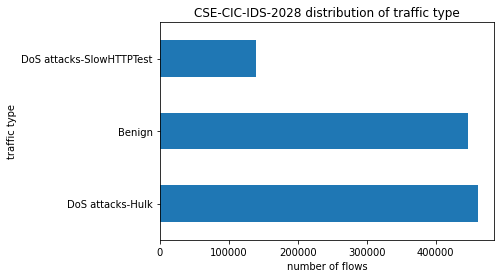

In [7]:
df['Label'].value_counts().plot(kind='barh')
plt.title('CSE-CIC-IDS-2028 distribution of traffic type')
plt.ylabel('traffic type')
plt.xlabel('number of flows')

## Tratamiento del Conjunto de Datos

### Data Cleaning

In [9]:
# Dropear valores nulos
df.dropna(1, inplace=True)

# Eliminamos características constantes
drop_cols = []
for col in df.columns:
    if len(df[col].unique())==1:
        drop_cols.append(col)
if drop_cols != []:
    df.drop(drop_cols, 1, inplace=True)

# Dropear filas con valores infinitos
to_drop_rows = []
num_df = df.drop(['Timestamp', 'Label'], axis=1)
to_drop_rows = list(df.index[np.isinf(num_df).any(1)])
df.drop(to_drop_rows, inplace=True)
del(num_df, to_drop_rows)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


In [10]:
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06
mean,2.002071e+04,5.999230e+00,2.432653e+06,3.215467e+00,1.655405e+00,4.035506e+02,1.922655e+02,4.028563e+02,4.718790e-03,8.216770e+01,1.817166e+02,1.687849e+02,5.225192e-03,5.476539e+01,9.317445e+01,8.429446e+02,9.855438e+04,3.379674e+05,8.507369e+05,2.347018e+06,1.512211e+04,2.431821e+06,6.274691e+05,1.177069e+06,2.367884e+06,1.621844e+04,6.509386e+05,2.020197e+05,3.496159e+05,6.357864e+05,3.135166e+03,4.959116e-05,1.074873e+02,5.511191e+01,4.954242e+04,4.901196e+04,4.291543e-03,4.172747e+02,6.380415e+01,1.406189e+02,4.435233e+04,1.208308e-03,4.959116e-05,2.861028e-06,1.470082e-01,8.516147e-01,2.517896e-02,2.861028e-06,1.943964e-01,7.155528e+01,8.216770e+01,5.476539e+01,3.215467e+00,4.035506e+02,1.655405e+00,1.922655e+02,4.144362e+03,9.499352e+01,4.490508e-01,3.303596e+01,1.776855e+02,2.680154e+01,2.037944e+02,1.550911e+02,7.829210e+05,9.144347e+01,7.829905e+05,7.828533e+05
std,2.376548e+04,8.539424e-02,6.177096e+06,1.646481e+00,2.099760e+00,4.586513e+02,2.183295e+03,4.576253e+02,1.146641e+00,9.275178e+01,2.056866e+02,2.097133e+02,1.299804e+00,6.550221e+01,1.116460e+02,1.135310e+04,2.754541e+05,1.017609e+06,2.098565e+06,6.017758e+06,6.997725e+05,6.177619e+06,1.689442e+06,3.017427e+06,6.031660e+06,7.157364e+05,5.692630e+06,1.775985e+06,3.147911e+06,5.676935e+06,1.505093e+05,7.041928e-03,5.447603e+01,7.057966e+01,1.376833e+05,1.378046e+05,1.134657e+00,4.650393e+02,7.154578e+01,1.567758e+02,4.965792e+04,3.473973e-02,7.041928e-03,1.691456e-03,3.541143e-01,3.554817e-01,1.566684e-01,1.691456e-03,4.057848e-01,8.027066e+01,9.275178e+01,6.550221e+01,1.646481e+00,4.586513e+02,2.099760e+00,2.183295e+03,9.441922e+03,1.124173e+02,5.848237e-01,2.818492e+00,1.882676e+04,1.166188e+04,2.913602e+04,1.341531e+04,5.886362e+06,3.721079e+04,5.886680e+06,5.886169e+06
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.663310e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000

### Correlación entre atributos

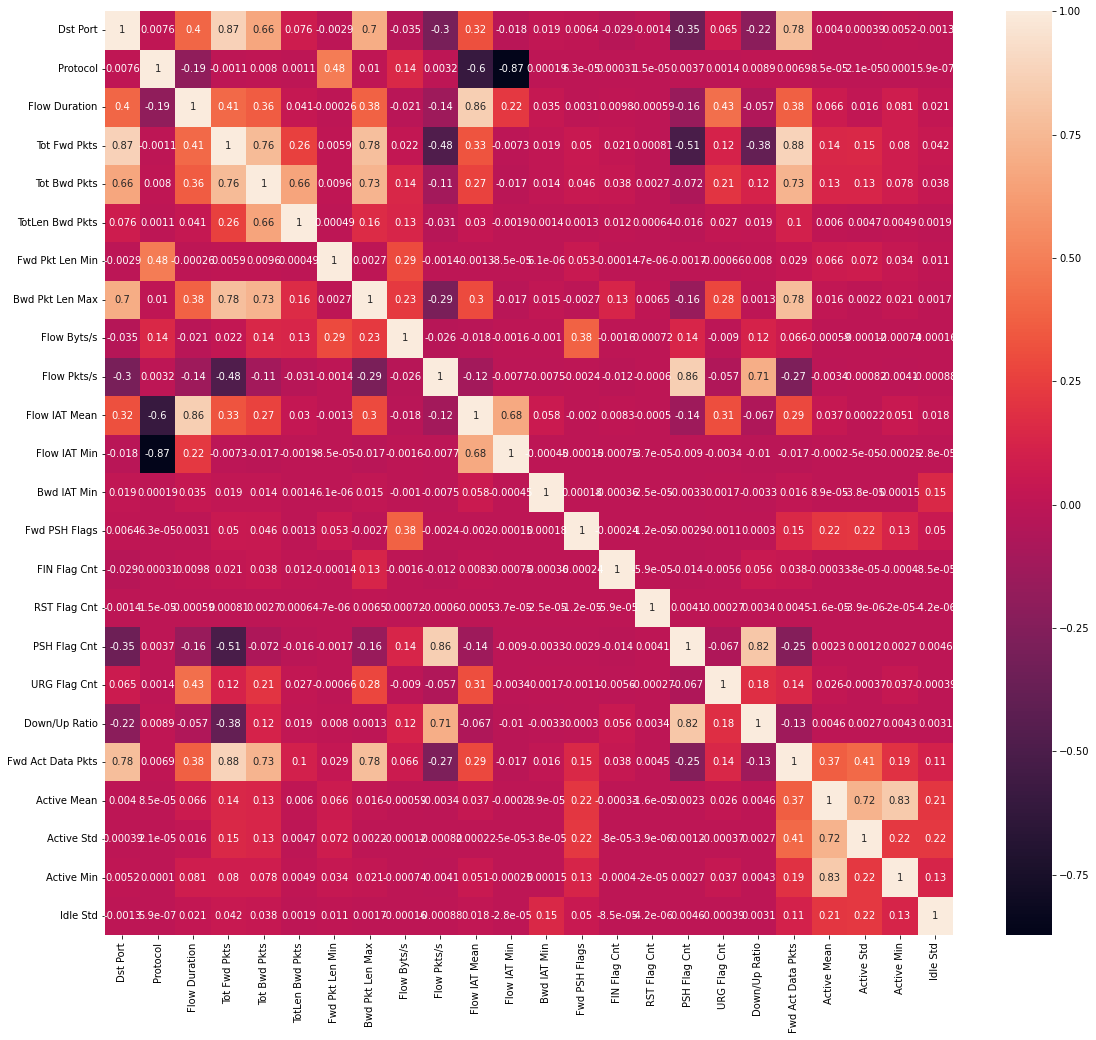

In [11]:
# Se eliminan características altamente correlacionadas
col_corr = set()
corr_matrix = df.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j])>0.90:
            colname = corr_matrix.columns[i]
            col_corr.add(colname)
df.drop(col_corr, axis=1, inplace=True)
del(corr_matrix, col_corr)

corr = df.corr()
plt.figure(figsize=(19,17))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()

In [12]:
df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max',
       'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Min',
       'Bwd IAT Min', 'Fwd PSH Flags', 'FIN Flag Cnt', 'RST Flag Cnt',
       'PSH Flag Cnt', 'URG Flag Cnt', 'Down/Up Ratio', 'Fwd Act Data Pkts',
       'Active Mean', 'Active Std', 'Active Min', 'Idle Std', 'Label'],
      dtype='object')

In [13]:
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Min,Bwd Pkt Len Max,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Min,Bwd IAT Min,Fwd PSH Flags,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,URG Flag Cnt,Down/Up Ratio,Fwd Act Data Pkts,Active Mean,Active Std,Active Min,Idle Std
count,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06
mean,2.002071e+04,5.999230e+00,2.432653e+06,3.215467e+00,1.655405e+00,1.922655e+02,4.718790e-03,1.687849e+02,8.429446e+02,9.855438e+04,3.379674e+05,1.512211e+04,3.135166e+03,4.959116e-05,1.208308e-03,2.861028e-06,1.470082e-01,2.517896e-02,1.943964e-01,4.490508e-01,1.776855e+02,2.680154e+01,1.550911e+02,9.144347e+01
std,2.376548e+04,8.539424e-02,6.177096e+06,1.646481e+00,2.099760e+00,2.183295e+03,1.146641e+00,2.097133e+02,1.135310e+04,2.754541e+05,1.017609e+06,6.997725e+05,1.505093e+05,7.041928e-03,3.473973e-02,1.691456e-03,3.541143e-01,1.566684e-01,4.057848e-01,5.848237e-01,1.882676e+04,1.166188e+04,1.341531e+04,3.721079e+04
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.663310e-02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+01,6.000000e+00,2.462000e+03,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.905502e+00,2.400000e+03,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,6.000000e+00,4.935100e+04,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.021152e+01,3.549025e+04,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.437600e+04,6.000000e+00,4.262940e+06,5.000000e+00,3.000000e+00,3.490000e+02,0.000000e+00,3.450000e+02,2.981807e+02,8.199242e+02,5.993361e+05,4.927000e+03,1.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.099800e+04,1.700000e+01,1.126418e+08,2.290000e+02,8.890000e+02,1.566268e+06,3.000000e+02,8.688000e+03,1.730137e+06,2.000000e+06,5.630000e+07,5.630000e+07,9.130000e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,2.190000e+02,8.797953e+06,7.912940e+06,7.247162e+06,2.480000e+07


### Outlier Treatment

In [14]:
cols = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 
        'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Flow Pkts/s', 'Flow Pkts/s',
        'Flow IAT Mean', 'Flow IAT Min', 'Bwd IAT Min', 'Down/Up Ratio', 
        'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Idle Std']

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', 
                      max_features=1.0, n_jobs=-1, bootstrap = False, random_state=42)
clf.fit(df[cols])
pred = clf.predict(df[cols])

In [15]:
df['anomaly'] = pred
outliers = df.loc[df['anomaly']==-1]
print(df['anomaly'].value_counts())
df.drop(['anomaly'], axis=1, inplace=True)
outlier_index = list(outliers.index)

 1    860475
-1    188099
Name: anomaly, dtype: int64


In [16]:
df.drop(outlier_index, inplace=True)
df.reset_index(drop=True, inplace = True)
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Min,Bwd Pkt Len Max,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Min,Bwd IAT Min,Fwd PSH Flags,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,URG Flag Cnt,Down/Up Ratio,Fwd Act Data Pkts,Active Mean,Active Std,Active Min,Idle Std
count,860475.000000,860475.0,8.604750e+05,860475.000000,860475.000000,860475.000000,860475.0,860475.000000,8.604750e+05,860475.000000,860475.000000,860475.000000,860475.000000,860475.000000,860475.0,860475.0,860475.000000,860475.000000,860475.000000,860475.000000,860475.000000,860475.0,860475.000000,860475.0
mean,21622.064624,6.0,2.028004e+06,3.380332,1.500886,170.628631,0.0,158.314381,1.713252e+02,37104.266047,289808.502759,6730.979983,3041.370271,0.000036,0.0,0.0,0.054822,0.007656,0.054821,0.457859,0.642332,0.0,0.642332,0.0
std,23982.090509,0.0,2.212001e+06,1.528292,1.559019,197.116676,0.0,173.404317,5.722181e+03,151630.056909,303969.386188,12038.473446,6920.621797,0.006002,0.0,0.0,0.227633,0.087164,0.227630,0.498221,88.265165,0.0,88.265165,0.0
min,21.000000,6.0,3.000000e+00,1.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,1.362912,3.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
25%,80.000000,6.0,4.905000e+03,2.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,1.890216,4905.000000,6.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
50%,80.000000,6.0,5.364400e+04,3.000000,1.000000,0.000000,0.0,0.000000,0.000000e+00,46.448976,38528.000000,9.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
75%,45512.000000,6.0,4.269510e+06,5.000000,3.000000,347.000000,0.0,344.000000,2.980319e+02,407.747197,604432.000000,7480.000000,1595.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0
max,60998.000000,6.0,6.603509e+06,6.000000,5.000000,842.000000,0.0,422.000000,1.062657e+06,666666.666700,829400.571400,54797.000000,63385.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,18076.000000,0.0,18076.000000,0.0


In [17]:
# Eliminamos características constantes
drop_cols = []
for col in df.columns:
    if len(df[col].unique())==1:
        drop_cols.append(col)
if drop_cols != []:
    df.drop(drop_cols, 1, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


In [18]:
value_count = df['Label'].value_counts()
value_rate = df['Label'].value_counts() / len(df['Label']) * 100
table = pd.concat([value_count, value_rate], axis=1)
table.columns = ['Count', '% of total Values']

display(table)

,Count,% of total Values
DoS attacks-Hulk,417573,48.528197
Benign,395730,45.989715
DoS attacks-SlowHTTPTest,47172,5.482088


### Transformación de atributos

In [19]:
# no se modelan días de la semana debido a que no hay información representativa sobre todos los días de la semana
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df.insert(2, 'xhr', np.sin(2*math.pi*df['Timestamp'].dt.hour/24))
df.insert(3, 'yhr', np.cos(2*math.pi*df['Timestamp'].dt.hour/24))
df.pop('Timestamp')
df

,Dst Port,xhr,yhr,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Bwd Pkts,Bwd Pkt Len Max,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Min,Bwd IAT Min,Fwd PSH Flags,PSH Flag Cnt,URG Flag Cnt,Down/Up Ratio,Fwd Act Data Pkts,Active Mean,Active Min,Label
0,40298,0.707107,-0.707107,928,2,0,0,0,9.137931e+05,2155.172414,928.0,928,0,1,0,0,0,0,0.0,0,Benign
1,51636,0.707107,-0.707107,841,2,0,0,0,1.008323e+06,2378.121284,841.0,841,0,1,0,0,0,0,0.0,0,Benign
2,51630,0.707107,-0.707107,874,2,0,0,0,9.702517e+05,2288.329519,874.0,874,0,1,0,0,0,0,0.0,0,Benign
3,44366,0.707107,-0.707107,864,2,0,0,0,9.814815e+05,2314.814815,864.0,864,0,1,0,0,0,0,0.0,0,Benign
4,55648,0.707107,-0.707107,893,2,0,0,0,9.496081e+05,2239.641657,893.0,893,0,1,0,0,0,0,0.0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860470,21,0.500000,-0.866025,3,1,1,0,0,0.000000e+00,666666.666700,3.0,3,0,0,1,0,1,0,0.0,0,DoS attacks-SlowHTTPTest
860471,21,0.500000,-0.866025,3,1,1,0,0,0.000000e+00,666666.666700,3.0,3,0,0,1,0,1,0,0.0,0,DoS attacks-SlowHTTPTest
860472,21,0.500000,-0.866025,3,1,1,0,0,0.000000e+00,666666.666700,3.0,3,0,0,1,0,1,0,0.0,0,DoS attacks-SlowHTTPTest
860473,21,0.500000,-0.866025,3,1,1,0,0,0.000000e+00,666666.666700,3.0,3,0,0,1,0,1,0,0.0,0,DoS attacks-SlowHTTPTest


In [20]:
# Cambiamos a un enfoque de clasificación binaria 0 -> normal, 1 -> ataque
df.replace(to_replace="Benign", value=1, inplace=True)
df.replace(to_replace="DoS attacks-SlowHTTPTest", value=-1, inplace=True)
df.replace(to_replace="DoS attacks-Hulk", value=-1, inplace=True)

value_count = df['Label'].value_counts()
value_rate = df['Label'].value_counts() / len(df['Label']) * 100
table = pd.concat([value_count, value_rate], axis=1)
table.columns = ['Count', '% of total Values']

display(table)

,Count,% of total Values
-1,464745,54.010285
1,395730,45.989715


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860475 entries, 0 to 860474
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           860475 non-null  int64  
 1   xhr                860475 non-null  float64
 2   yhr                860475 non-null  float64
 3   Flow Duration      860475 non-null  int64  
 4   Tot Fwd Pkts       860475 non-null  int64  
 5   Tot Bwd Pkts       860475 non-null  int64  
 6   TotLen Bwd Pkts    860475 non-null  int64  
 7   Bwd Pkt Len Max    860475 non-null  int64  
 8   Flow Byts/s        860475 non-null  float64
 9   Flow Pkts/s        860475 non-null  float64
 10  Flow IAT Mean      860475 non-null  float64
 11  Flow IAT Min       860475 non-null  int64  
 12  Bwd IAT Min        860475 non-null  int64  
 13  Fwd PSH Flags      860475 non-null  int64  
 14  PSH Flag Cnt       860475 non-null  int64  
 15  URG Flag Cnt       860475 non-null  int64  
 16  Do

In [23]:
df.describe()

,Dst Port,xhr,yhr,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Bwd Pkts,Bwd Pkt Len Max,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Min,Bwd IAT Min,Fwd PSH Flags,PSH Flag Cnt,URG Flag Cnt,Down/Up Ratio,Fwd Act Data Pkts,Active Mean,Active Min,Label
count,860475.000000,8.604750e+05,860475.000000,8.604750e+05,860475.000000,860475.000000,860475.000000,860475.000000,8.604750e+05,860475.000000,860475.000000,860475.000000,860475.000000,860475.000000,860475.000000,860475.000000,860475.000000,860475.000000,860475.000000,860475.000000,860475.000000
mean,21622.064624,2.720486e-01,0.865423,2.028004e+06,3.380332,1.500886,170.628631,158.314381,1.713252e+02,37104.266047,289808.502759,6730.979983,3041.370271,0.000036,0.054822,0.007656,0.054821,0.457859,0.642332,0.642332,-0.080206
std,23982.090509,5.493806e-02,0.417151,2.212001e+06,1.528292,1.559019,197.116676,173.404317,5.722181e+03,151630.056909,303969.386188,12038.473446,6920.621797,0.006002,0.227633,0.087164,0.227630,0.498221,88.265165,88.265165,0.996779
min,21.000000,1.224647e-16,-1.000000,3.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000e+00,1.362912,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,80.000000,2.588190e-01,0.965926,4.905000e+03,2.000000,0.000000,0.000000,0.000000,0.000000e+00,1.890216,4905.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,80.000000,2.588190e-01,0.965926,5.364400e+04,3.000000,1.000000,0.000000,0.000000,0.000000e+00,46.448976,38528.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
75%,45512.000000,2.588190e-01,0.965926,4.269510e+06,5.000000,3.000000,347.000000,344.000000,2.980319e+02,407.747197,604432.000000,7480.000000,1595.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,60998.000000,7.071068e-01,0.965926,6.603509e+06,6.000000,5.000000,842.000000,422.000000,1.062657e+06,666666.666700,829400.571400,54797.000000,63385.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18076.000000,18076.000000,1.000000


Text(0.5, 1.0, 'Correlación respecto a target')

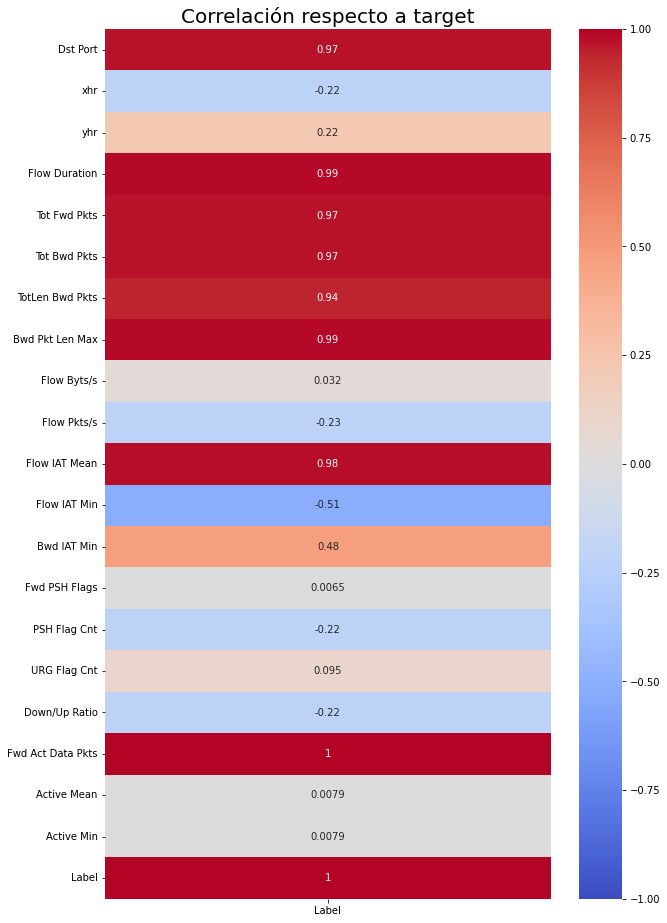

In [24]:
corr = df.corr()

kot = corr
plt.figure(figsize=(10,16))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación respecto a target', fontsize=20)

## Preprocesado

In [25]:
num_cols = df.columns[:-1]
df[num_cols] = preprocessing.MinMaxScaler().fit_transform(df[num_cols])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Label'], axis=1), 
                                                    df['Label'], 
                                                    test_size=0.3, 
                                                    random_state=42)

### Modelado

In [27]:
clfIF = IsolationForest(max_samples=0.25, random_state=42, contamination=0.6, n_estimators=20, n_jobs=-1)

In [28]:
%%time
clfIF.fit(X_train, y_train)
pred_train = clfIF.predict(X_train)

CPU times: user 18 s, sys: 3.53 s, total: 21.5 s
Wall time: 17.2 s


### Resultados

              precision    recall  f1-score   support

      normal       0.73      0.81      0.77    325277
     anomaly       0.75      0.65      0.69    277055

    accuracy                           0.74    602332
   macro avg       0.74      0.73      0.73    602332
weighted avg       0.74      0.74      0.73    602332

AUC: 73.0%


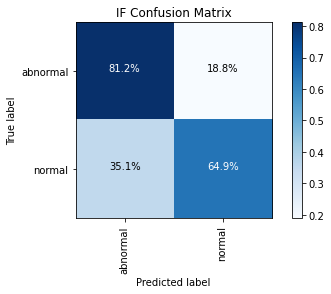

In [29]:
print(classification_report(y_train, pred_train, target_names=['normal', 'anomaly']))
print('AUC:','{:.1%}'.format(roc_auc_score(y_train, pred_train)))
cm = confusion_matrix(y_train, pred_train)
plot_confusion_matrix(cm, title='IF Confusion Matrix')

## IF tunning

In [30]:
scoring = {'AUC': 'roc_auc', 'Recall' : make_scorer(recall_score, pos_label=-1)}

In [31]:
gs = GridSearchCV(IsolationForest(
                    max_samples=0.25,
                    random_state=42,
                    contamination=0.6,
                    n_jobs=-1),
                  param_grid={'n_estimators': range(20, 230, 30)},
                  scoring=scoring,
                  refit='Recall'
                 )
gs.fit(X_train, y_train)
results = gs.cv_results_

In [32]:
results

{'mean_fit_time': array([ 7.02825685, 15.95080304, 25.28683434, 34.19174929, 42.93014312,
        52.19209204, 58.57488689]),
 'std_fit_time': array([0.36041546, 0.19068839, 0.58063776, 0.86846783, 0.83094399,
        0.7991707 , 2.0905694 ]),
 'mean_score_time': array([ 2.46982503,  6.03253555,  9.63985348, 12.98309751, 16.27753935,
        19.71634216, 22.47361722]),
 'std_score_time': array([0.03386429, 0.05073465, 0.06040318, 0.02744148, 0.14171467,
        0.21025637, 0.17326281]),
 'param_n_estimators': masked_array(data=[20, 50, 80, 110, 140, 170, 200],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 20},
  {'n_estimators': 50},
  {'n_estimators': 80},
  {'n_estimators': 110},
  {'n_estimators': 140},
  {'n_estimators': 170},
  {'n_estimators': 200}],
 'split0_test_AUC': array([0.66630195, 0.71497747, 0.72513845, 0.74449648, 0.74647988,
        0.74202386, 0.74544368]),
 'split

110.0
20.0


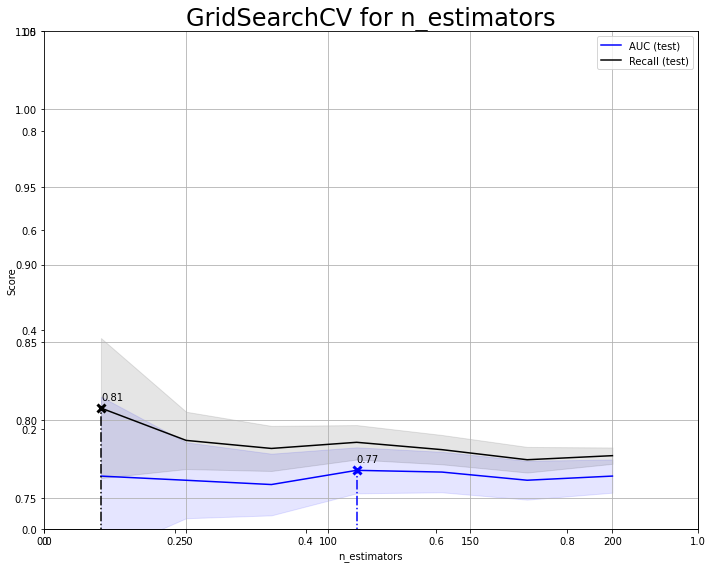

In [33]:
plot_gridsearch_cv(results, 'n_estimators', 0, 230, 0.73, 1.05)

In [34]:
gs = GridSearchCV(IsolationForest(
                    n_estimators=125,
                    random_state=42,
                    contamination=0.6,
                    n_jobs=-1),
                  param_grid={'max_samples': np.arange(0.1, 1.0, 0.1)},
                  scoring=scoring,
                  refit='Recall'
                 )
gs.fit(X_train, y_train)
results = gs.cv_results_

0.6
0.6


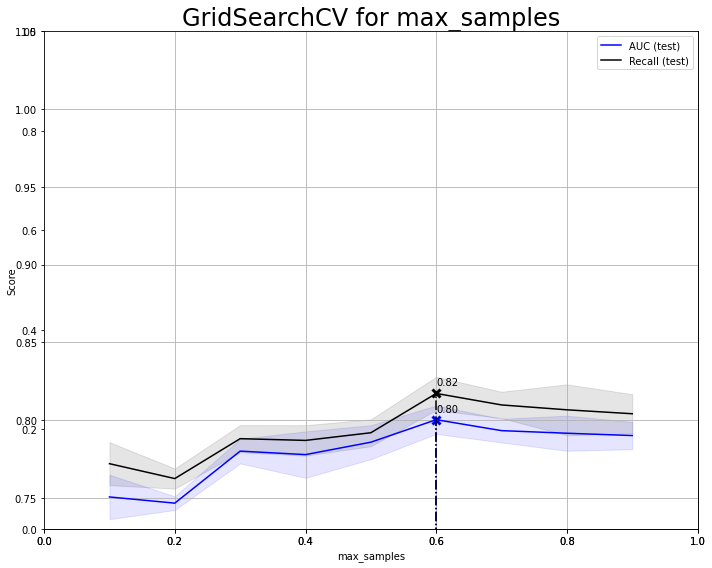

In [37]:
plot_gridsearch_cv(results, 'max_samples', 0, 1, 0.73, 1.05)

In [36]:
results

{'mean_fit_time': array([33.51833744, 34.94202819, 42.67589693, 42.37438231, 42.99173532,
        46.48504386, 46.70179071, 47.03770752, 46.98203478]),
 'std_fit_time': array([1.16857865, 1.01656517, 0.70391171, 0.52358082, 0.61947093,
        0.26821943, 0.26739351, 0.18062663, 0.23182544]),
 'mean_score_time': array([12.97107606, 14.19848552, 15.22850361, 15.12544088, 15.0730639 ,
        16.11666026, 16.46369896, 16.29192324, 16.24921594]),
 'std_score_time': array([0.07611681, 0.02896398, 0.18126461, 0.10325083, 0.16427903,
        0.09554433, 0.20679425, 0.17565799, 0.16953906]),
 'param_max_samples': masked_array(data=[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                    0.7000000000000001, 0.8, 0.9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'max_samples': 0.1},
  {'max_samples': 0.2},
  {'max_samples': 0.30000000000000004},
  {'max_samples'

In [44]:
clfIF = IsolationForest(max_samples=0.6, random_state=42, contamination=0.6, n_estimators=115, n_jobs=-1)

In [45]:
%%time
clfIF.fit(X_train, y_train)
pred_train = clfIF.predict(X_test)

CPU times: user 1min 34s, sys: 12.4 s, total: 1min 47s
Wall time: 1min 10s


              precision    recall  f1-score   support

      normal       0.72      0.80      0.75    139468
     anomaly       0.73      0.63      0.67    118675

    accuracy                           0.72    258143
   macro avg       0.72      0.71      0.71    258143
weighted avg       0.72      0.72      0.72    258143

AUC: 71.2%


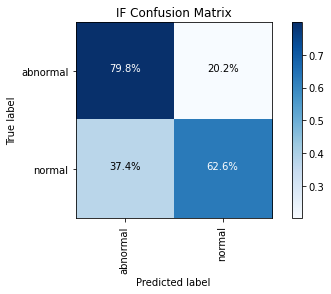

In [46]:
print(classification_report(y_test, pred_train, target_names=['normal', 'anomaly']))
print('AUC:','{:.1%}'.format(roc_auc_score(y_test, pred_train)))
cm = confusion_matrix(y_test, pred_train)
plot_confusion_matrix(cm, title='IF Confusion Matrix')